In [41]:
import numpy as np
import ufl

from mpi4py import MPI
from petsc4py.PETSc import ScalarType

from dolfinx import mesh, fem, plot, io
from dolfinx.io import XDMFFile, gmshio

import gmsh

import pyvista
# pyvista.set_jupyter_backend('panel');
# pyvista.set_jupyter_backend('pythreejs');
# pyvista.set_jupyter_backend('ipygany')
pyvista.set_jupyter_backend('static');

Defining the phisical properties of fibres

In [42]:
ν = 0.3
E = 2.1e10

λ = ν*E/(1+ν)/(1-2*ν)
μ = E/2/(1+ν)

ORDER = 2

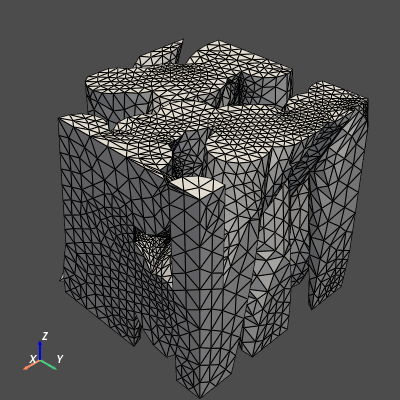

In [43]:
## Setting up gmsh properties
gmsh.initialize()

# Choose if Gmsh output is verbose
gmsh.option.setNumber("General.Terminal", 0)

# Set elements order to the specified one
gmsh.option.setNumber("Mesh.ElementOrder", ORDER)
# Set elements size
# gmsh.option.setNumber("Mesh.MeshSizeFromCurvature", 5) # uncomment to use for mesh refinement dependending from its surface curvature
gmsh.option.setNumber("Mesh.MeshSizeMax", 5e-2)
gmsh.option.setNumber("Mesh.MeshSizeMin", 1e-2)

# Set threads number for distrebuted meshing
# gmsh.option.setNumber("Mesh.MaxNumThreads3D", 4)

# Set mesh algorithm (default is Delaunay triangulation)
# see https://gmsh.info/doc/texinfo/gmsh.html#Choosing-the-right-unstructured-algorithm
gmsh.option.setNumber("Mesh.Algorithm3D", 3)

# gmsh.option.setNumber("Mesh.RecombinationAlgorithm",3)
# gmsh.option.setNumber("Mesh.Recombine3DAll",1)

# Set the usage of hexahedron elements 
gmsh.option.setNumber("Mesh.SubdivisionAlgorithm", 0)
## Importing RVE geometry
gmsh.open("in/test_rve(tet10)_1.msh")

model = gmsh.model()
# model.add("main_domain")
model_name = model.getCurrent()
tags = [dimtag[1] for dimtag in model.get_entities(3)]

model.add_physical_group(dim=3, tags=tags)


# Synchronize OpenCascade representation with gmsh model
model.occ.synchronize()


# Generate the mesh
# model.mesh.generate(2)
# model.mesh.recombine()
model.mesh.generate(dim=3)

bbox = [np.Inf,
        np.Inf,
        np.Inf,
        -np.Inf,
        -np.Inf,
        -np.Inf]
for tag in tags:
    buf_bbox = model.get_bounding_box(3, tag)
    for i in range(3):
        if bbox[i] > buf_bbox[i]:
            bbox[i] = buf_bbox[i]
    for j in range(3,6):
        if bbox[j] < buf_bbox[j]:
            bbox[j] = buf_bbox[j]
            
            
# Create a DOLFINx mesh (same mesh on each rank)
msh, cell_markers, facet_markers = gmshio.model_to_mesh(model, MPI.COMM_SELF,0)
msh.name = "Box"
cell_markers.name = f"{msh.name}_cells"
facet_markers.name = f"{msh.name}_facets"

# Finalize gmsh to be able to use it again
gmsh.finalize()


with io.XDMFFile(msh.comm, "out/imported_mesh.xdmf", "w") as file:
    file.write_mesh(msh)
    file.write_meshtags(cell_markers)
    msh.topology.create_connectivity(msh.topology.dim - 1, msh.topology.dim)
    file.write_meshtags(facet_markers)

    
# visualize using pyvista
# to use it, ipycanvas and ipyvtklink py needs to be installed
# Just run in terminal:
# ~# pip install ipyvtklink ipycanvas
pyvista.start_xvfb()

# Create plotter and pyvista grid
p = pyvista.Plotter(window_size=[400, 400])
topology, cell_types, geometry = plot.create_vtk_mesh(msh)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

actor_0 = p.add_mesh(grid, show_edges=True)#style="wireframe", color="k")

p.show_axes()
if not pyvista.OFF_SCREEN:
   p.show()
else:
   figure_as_array = p.screenshot("mesh.png")

In [44]:
# T = fem.Constant(msh, ScalarType((0., 0., 0.)))
# ds = ufl.Measure("ds", domain=msh)
def epsilon(u):
    return ufl.sym(ufl.grad(u)) # Equivalent to 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)
def sigma(u):
    return λ * ufl.nabla_div(u) * ufl.Identity(len(u)) + 2*μ*epsilon(u)


V = fem.VectorFunctionSpace(msh, ("CG", ORDER))
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
f = fem.Constant(msh, ScalarType((0., 0., 0.)))
a = ufl.inner(sigma(u), epsilon(v)) * ufl.dx
L = ufl.dot(f, v) * ufl.dx #+ ufl.dot(T, v) * ds

Marking nodes on each side of the RVE by following:
- left (x = -1) - 1;
- right (x = 1) - 2;
- bottom (z = -1) - 3;
- top (z = 1) - 4;
- front (y = -1) - 5;
- back (y = 1) - 6;

In [45]:
eps = np.linalg.norm(np.array(bbox[0:3]) + np.array(bbox[3:]));
np.isclose

<function numpy.isclose(a, b, rtol=1e-05, atol=1e-08, equal_nan=False)>

In [46]:
bbox

[-1.000000000000003,
 -1.000000000000001,
 -1.000000000000048,
 1.000000000000001,
 1.004077872060019,
 1.000000000011717]

In [47]:
def left(x):
    return np.isclose(x[0], bbox[0], atol = eps);

def right(x):
    return np.isclose(x[0], bbox[3], atol = eps);

def bottom(x):
    return np.isclose(x[2], bbox[2], atol = eps);

def top(x):
    return np.isclose(x[2], bbox[5], atol = eps);

def front(x):
    return np.isclose(x[1], bbox[1], atol = eps);

def back(x):
    return np.isclose(x[1], bbox[4], atol = eps);

fdim = msh.topology.dim - 1

# find all facets on top, bottom and left boundary
left_facets = mesh.locate_entities_boundary(msh, fdim, left);
right_facets = mesh.locate_entities_boundary(msh, fdim, right);
bottom_facets = mesh.locate_entities_boundary(msh, fdim, bottom);
top_facets = mesh.locate_entities_boundary(msh, fdim, top);
front_facets = mesh.locate_entities_boundary(msh, fdim, front);
back_facets = mesh.locate_entities_boundary(msh, fdim, back);

In [48]:
marked_facets = np.hstack([left_facets, 
                           right_facets, 
                           bottom_facets,
                           top_facets,
                           front_facets,
                           back_facets,
                          ]);

markers = np.hstack([np.full_like(left_facets, 1),
                     np.full_like(right_facets, 2),
                     np.full_like(bottom_facets, 3),
                     np.full_like(top_facets, 4),
                     np.full_like(front_facets, 5),
                     np.full_like(back_facets, 6),
                    ]);

facets_order = np.argsort(marked_facets);

facets_tags = mesh.meshtags(msh, 
                            fdim, 
                            marked_facets[facets_order],
                            markers[facets_order]);

ds = ufl.Measure('ds', domain=msh, subdomain_data=facets_tags);

Firstly, we want to compress across Z direction, so
1. facets on bottom should be fixed in all diractions $(u_3 = (0.0, 0.0, 0.0)$);
2. facets on top should be shifted across Z diraction on unit distance $(u_4 = (0.0, 0.0, 0.1))$;
3. facets on other sides should be constrained in XY plane $(u_{i,j} = 0.0$, where $i \in \{1, 2, 3, 4\}$, $j \in \{1, 2\})$;
4. *facets on left, right, front and back sides should be shifted according to linear low* $u_{i,3}(z) = \frac{z-z_{\min}}{z_{\max} - z_{\min}}$

In [49]:
unit_disp = 0.1;

In [50]:
# apply 1st constraint to the bottom RVE's facet
bottom_dofs = fem.locate_dofs_topological(V, 
                                        facets_tags.dim, 
                                        facets_tags.find(3)); # since bottom facets has mark 3
ub_3 = np.array([0., 0., 0.], dtype = ScalarType);
bc_bottom = fem.dirichletbc(ub_3, 
                       bottom_dofs,
                       V);

In [51]:
# # apply 2nd constraint to the top RVE's facet
# top_dofs = fem.locate_dofs_topological(V, 
#                                            facets_tags.dim, 
#                                            facets_tags.find(4)); # since top facets has mark 4

# ub_4 = np.array([0., 0., unit_disp], dtype = ScalarType);
# bc_top = fem.dirichletbc(ub_4,
#                        top_dofs,
#                        V);

In [52]:
# # apply 3rd constraint
# facets = np.hstack([facets_tags.find(1),
#                     facets_tags.find(2), 
#                     facets_tags.find(5),
#                     facets_tags.find(6),
#                    ]);
# side_xdofs = fem.locate_dofs_topological(V.sub(0),
#                                          facets_tags.dim,
#                                          facets);
# side_ydofs = fem.locate_dofs_topological(V.sub(1),
#                                          facets_tags.dim,
#                                          facets);

# bc_sidex = fem.dirichletbc(ScalarType(0),
#                            side_xdofs,
#                            V.sub(0));
# bc_sidey = fem.dirichletbc(ScalarType(0),
#                            side_ydofs,
#                            V.sub(1));

In [53]:
# # apply 4th constraint
# ub_sidez = fem.Function(V.sub(2).collapse()[0]);

# def side_z(x):
#     # values = np.zeros(x.shape[1]);
#     values = unit_disp*(x[2] - bbox[2])/(bbox[5] - bbox[2]);
#     return values;

# ub_sidez.interpolate(side_z);

# side_zdofs = fem.locate_dofs_topological(V.sub(2),
#                                          facets_tags.dim,
#                                          facets);
# bc_sidez = fem.dirichletbc(ub_sidez,
#                            side_zdofs);

In [54]:
# apply 2nd, 3rd and 4th constraints
facets = np.hstack([facets_tags.find(1),
                    facets_tags.find(2),
                    facets_tags.find(4),
                    facets_tags.find(5),
                    facets_tags.find(6),
                   ]);

ub_ = fem.Function(V);

def full_bc(x):
    values = np.zeros(x.shape);
    values[2,:] = unit_disp*(x[2] - bbox[2])/(bbox[5] - bbox[2]);
    return values;

ub_.interpolate(full_bc);

nonbottom_dofs = fem.locate_dofs_topological(V,
                                         facets_tags.dim,
                                         facets);
bc_ = fem.dirichletbc(ub_, nonbottom_dofs);

In [55]:
# problem = fem.petsc.LinearProblem(a, L, bcs=[bc_bottom, bc_top, bc_sidex, bc_sidey, bc_sidez], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
problem = fem.petsc.LinearProblem(a, L, bcs=[bc_bottom, bc_], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})

uh = problem.solve()

## Visualzation

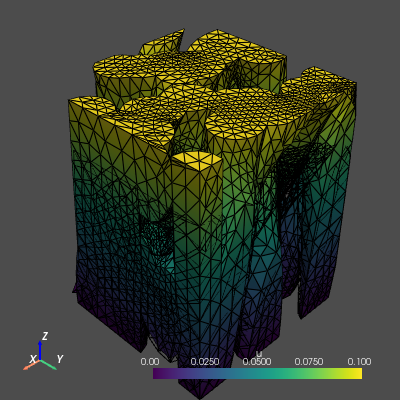

In [56]:
uh.name = "Deformation"

    

# # write mesh to XDMF file
# with io.XDMFFile(msh.comm, "out/deformation.xdmf", "w") as xdmf:
#     xdmf.write_mesh(msh)
#     xdmf.write_function(uh)


# visualize using pyvista
# to use it, ipycanvas and ipyvtklink py needs to be installed
# Just run in terminal:
# ~# pip install ipyvtklink ipycanvas
pyvista.start_xvfb()

# Create plotter and pyvista grid
p = pyvista.Plotter(window_size=[400, 400])
topology, cell_types, geometry = plot.create_vtk_mesh(msh)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# # Attach vector values to grid and warp grid by vector
grid["u"] = uh.x.array.reshape((geometry.shape[0], 3))
actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=5.0)
actor_1 = p.add_mesh(warped, show_edges=True)
p.show_axes()
if not pyvista.OFF_SCREEN:
   p.show()
else:
   figure_as_array = p.screenshot("deformation.png")

In [57]:
def macro_strain(i):
    """returns the macroscopic strain for the 3 elementary load cases"""
    ϵ = np.zeros((6,), dtype = np.float64)
    ϵ[i] = 1;
    ϵ[3:] /= 2;
    return np.array([[ϵ[0], ϵ[5], ϵ[4]],
                     [ϵ[5], ϵ[1], ϵ[3]],
                     [ϵ[4], ϵ[3], ϵ[2]]]);
ε = fem.Constant
def stress2Voigt(s):
    return ufl.as_vector([s[0,0], 
                          s[1,1], 
                          s[2,2],
                          s[1,2],
                          s[0,2],
                          s[0,1]])



# Homogenization of elastic properties

For homogeinzation procedure we wil use the Voigt notation, according to which the stress and strein tensors are represented as a vectors:

$$
    \mathbf{\varepsilon} = 
    \left\{
        \begin{matrix}
            \varepsilon_{11} \\ 
            \varepsilon_{22} \\ 
            \varepsilon_{33} \\ 
            \varepsilon_{23} \\ 
            \varepsilon_{13} \\ 
            \varepsilon_{12} \\
        \end{matrix}
    \right\}
    = 
    \left\{
        \begin{matrix}
            \varepsilon_{x} \\ 
            \varepsilon_{y} \\ 
            \varepsilon_{z} \\ 
            \gamma_{yz}\\
            \gamma_{xz}\\
            \gamma_{xy}\\ 
        \end{matrix}
    \right\};\hspace{2cm}
    \mathbf{\sigma} = 
    \left\{
        \begin{matrix}
            \sigma_{11} \\ 
            \sigma_{22} \\ 
            \sigma_{33} \\ 
            \sigma_{23} \\ 
            \sigma_{13} \\ 
            \sigma_{12} \\
        \end{matrix}
    \right\}
    = 
    \left\{
        \begin{matrix}
            \sigma_{x} \\ 
            \sigma_{y} \\ 
            \sigma_{z} \\ 
            \tau_{yz}\\
            \tau_{xz}\\
            \tau_{xy}\\ 
        \end{matrix}
    \right\};
$$
Then the stiffness can be determined as
$$
    \hat{\sigma} = \mathbf{\hat{C}}\hat{\varepsilon},
$$
where $\mathbf{\hat{C}}$ is averaged matrix of elastic properties, $ \hat{\varepsilon}~-$  an average strein within the RVEvolume, which is determined by the BC and $\hat{\sigma}~-$  an average stress within the RVE's volume, which is determined according to
$$
    \hat{\sigma} = \frac{1}{V}\int_\Omega{\sigma (x) dx}, 
$$
where V - RVE volume and $\Omega$ - RVE domain.


To determine an avarage elastic properties of the material we need to solve 6 different  boundary problems:
$$
    \hat{\varepsilon}_{1} = 
    \left\{
        \begin{matrix} 1\\ 0\\ 0\\ 0\\ 0\\ 0\\ \end{matrix}
    \right\};\ 
    \hat{\varepsilon}_{2} = 
    \left\{
        \begin{matrix} 0\\ 1\\ 0\\ 0\\ 0\\ 0\\ \end{matrix}
    \right\};\ 
    \hat{\varepsilon}_{3} = 
    \left\{
        \begin{matrix} 0\\ 0\\ 1\\ 0\\ 0\\ 0\\ \end{matrix}
    \right\};\ 
    \hat{\varepsilon}_{4} = 
    \left\{
        \begin{matrix} 0\\ 0\\ 0\\ 1\\ 0\\ 0\\ \end{matrix}
    \right\};\ 
    \hat{\varepsilon}_{5} = 
    \left\{
        \begin{matrix} 0\\ 0\\ 0\\ 0\\ 1\\ 0\\ \end{matrix}
    \right\};\ 
    \hat{\varepsilon}_{6} = 
    \left\{
        \begin{matrix} 0\\ 0\\ 0\\ 0\\ 0\\ 1\\ \end{matrix}
    \right\};\
$$

in each case we obtain we obtain a certain value of Voigt stress vector. Full series of calculation will give us following SLE:

$$
    \begin{bmatrix}
        \hat{\sigma}_{x}^1 & \hat{\sigma}_{x}^2 & \hat{\sigma}_{x}^3 & \hat{\sigma}_{x}^4 & \hat{\sigma}_{x}^5 & \hat{\sigma}_{x}^6 \\
        \hat{\sigma}_{y}^1 & \hat{\sigma}_{y}^2 & \hat{\sigma}_{y}^3 & \hat{\sigma}_{y}^4 & \hat{\sigma}_{y}^5 & \hat{\sigma}_{y}^6 \\ 
        \hat{\sigma}_{z}^1 & \hat{\sigma}_{z}^2 & \hat{\sigma}_{z}^3 & \hat{\sigma}_{z}^4 & \hat{\sigma}_{z}^5 & \hat{\sigma}_{z}^6 \\ 
        \hat{\tau}_{yz}^1 & \hat{\tau}_{yz}^2 & \hat{\tau}_{yz}^3 & \hat{\tau}_{yz}^4 & \hat{\tau}_{yz}^5 & \hat{\tau}_{yz}^6 \\ 
        \hat{\tau}_{xz}^1 & \hat{\tau}_{xz}^2 & \hat{\tau}_{xz}^3 & \hat{\tau}_{xz}^4 & \hat{\tau}_{xz}^5 & \hat{\tau}_{xz}^6 \\
        \hat{\tau}_{xy}^1 & \hat{\tau}_{xy}^2 & \hat{\tau}_{xy}^3 & \hat{\tau}_{xy}^4 & \hat{\tau}_{xy}^5 & \hat{\tau}_{xy}^6 \\
    \end{bmatrix}
    =
    \mathbf{\hat{C}}
    \begin{bmatrix}
        1 & 0 & 0 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 & 0 & 0 \\
        0 & 0 & 1 & 0 & 0 & 0 \\
        0 & 0 & 0 & 1 & 0 & 0 \\
        0 & 0 & 0 & 0 & 1 & 0 \\
        0 & 0 & 0 & 0 & 0 & 1 \\
    \end{bmatrix}
$$
since Voigt strein matrix actualy is a unit matrix, then the avareged elastic matrix $\mathbf{\hat{C}}$ will be equal to the matrix of calulated stress 
$\begin{bmatrix} \hat{\sigma}^1 &\hat{\sigma}^2 & \hat{\sigma}^3 & \hat{\sigma}^4 & \hat{\sigma}^5 & \hat{\sigma}^6 \end{bmatrix}$

In [63]:
s_1 = np.sum(stress2Voigt(sigma(uh))[1]*ufl.dx)

In [59]:
a = s_1.integrals()

In [61]:
Chom = np.zeros((6, 6));
for (j, case) in enumerate(["εxx", "εyy", "εzz", "εyz", "εxz", "εxy"]):
    print("Solving {} case...".format(case));
    

Solving εxx case...
Solving εyy case...
Solving εzz case...
Solving εyz case...
Solving εxz case...
Solving εxy case...


In [62]:
ufl.as_vector([1, 2, 3,])

ListTensor(IntValue(1), IntValue(2), IntValue(3))